In [1]:
%matplotlib inline

In [55]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
import pandas as pd
import numpy as np
import json

In [18]:
train = pd.read_csv("data/train.csv", header=None)
test = pd.read_csv("data/test.csv", header=None)

In [32]:
train_X = train.iloc[:, 1:].to_numpy()
train_y = np.array(train.iloc[:, 0].map(json.loads).tolist())

test_X = test.iloc[:, 1:].to_numpy()
test_y = np.array(test.iloc[:, 0].map(json.loads).tolist())

In [34]:
test_y

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [71]:
def model_from_sentiment():
    with open("../sentiment/model/model.json") as f:
        model = model_from_json(f.read())
        model.load_weights("../sentiment/model/model.h5")
        
    layers = model.layers
    layers.pop()
    layers.append(Dense(2, activation="softmax"))
    
    model = Sequential(layers)
    return model

def model_from_scratch():
    model = Sequential([
        Embedding(3000, 64, input_length=256),

        Conv1D(128, 7, activation='relu', padding='valid'),
        MaxPool1D(pool_size=3),
        Dropout(0.1),

        Conv1D(128, 7, activation='relu', padding='valid'),
        MaxPool1D(pool_size=3),
        Dropout(0.1),

        Conv1D(128, 3, activation='relu', padding='valid'),
        MaxPool1D(pool_size=3),
        Dropout(0.1),

        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
    return model

# model = model_from_scratch()
model = model_from_sentiment()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 256, 64)           192000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 83, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 77, 128)           114816    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 128)           0         
__________

In [75]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

hist = model.fit(train_X, train_y, epochs=30, verbose=1, callbacks=[es], validation_data=(test_X, test_y))

Train on 2010 samples, validate on 600 samples
Epoch 1/30
2010/2010 [==============================] - 1s 492us/step - loss: 0.0145 - acc: 0.9975 - val_loss: 0.8118 - val_acc: 0.8517
Epoch 2/30
2010/2010 [==============================] - 1s 442us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.9821 - val_acc: 0.8467
Epoch 3/30
2010/2010 [==============================] - 1s 462us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 1.1535 - val_acc: 0.8550
Epoch 4/30
2010/2010 [==============================] - 1s 447us/step - loss: 0.0021 - acc: 0.9990 - val_loss: 1.1248 - val_acc: 0.8467
Epoch 5/30
2010/2010 [==============================] - 1s 473us/step - loss: 0.0316 - acc: 0.9905 - val_loss: 1.0934 - val_acc: 0.8250
Epoch 6/30
2010/2010 [==============================] - 1s 489us/step - loss: 0.0355 - acc: 0.9905 - val_loss: 0.6467 - val_acc: 0.8433
Epoch 7/30
2010/2010 [==============================] - 1s 449us/step - loss: 0.0082 - acc: 0.9970 - val_loss: 0.7324 - val_acc: 0.8583
E

In [76]:
model.evaluate(test_X, test_y)

600/600 [==============================] - 0s 170us/step


[0.9788491185506185, 0.8566666666666667]

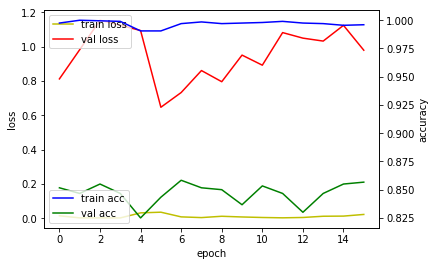

In [77]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()